In [24]:
!pip install torchmetrics

In [25]:
!pip install lightgbm

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import joblib

from sklearn.multioutput import MultiOutputRegressor
from sklearn.base import clone
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold

from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torchmetrics import MeanSquaredError, MeanAbsoluteError
import torch.nn.functional as F
from tqdm import tqdm

import lightgbm as lgb

import time

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

if device.type == "cuda":
    print("CUDA is available!")
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("Running on CPU.")

Using: cpu
Running on CPU.


# Load & Inspect Data


In [28]:
npz_path = "pems08.npz"
data = np.load(npz_path)

print("Keys in .npz file:", data.files)

Keys in .npz file: ['data']


In [29]:
graph_signal = data['data']
print("Signal shape:", graph_signal.shape)

Signal shape: (17856, 170, 3)


17856 time steps → with 5-min intervals:
17856 / 12 ≈ 1488 hours = ~62 days → consistent with July–August 2016

170 sensors

3 features: flow, occupancy, speed


In [30]:
distance_df = pd.read_csv("distance.csv")

print(distance_df.head())

   from   to   cost
0     9  153  310.6
1   153   62  330.9
2    62  111  332.9
3   111   11  324.2
4    11   28  336.0


# Handling Missing Values


In [31]:
# Apply linear interpolation per sensor & feature (accor. to research paper)
for sensor in range(graph_signal.shape[1]):
    for feature in range(graph_signal.shape[2]):
        s = pd.Series(graph_signal[:, sensor, feature])
        graph_signal[:, sensor, feature] = s.interpolate(method='linear', limit_direction='both').values

# Zero-mean normalization


In [32]:
mean_per_sensor_feature = graph_signal.mean(axis=0)  # shape (170, 3)
graph_signal_centered = graph_signal - mean_per_sensor_feature  # broadcast over time

# Building adjacency matrix (with ≥3.5 miles filter)


In [33]:
num_nodes = 170
adj_matrix = np.zeros((num_nodes, num_nodes))

for _, row in distance_df.iterrows():
    i, j, dist = int(row['from']), int(row['to']), float(row['cost'])
    if dist >= 3.5:
        adj_matrix[i, j] = 1 / dist  # weighted edge

# Make symmetric
adj_matrix = np.maximum(adj_matrix, adj_matrix.T)

In [34]:
adj_tensor = torch.tensor(adj_matrix, dtype=torch.float32).to(device)

In [35]:
adj_tensor.shape

torch.Size([170, 170])

# Normalize adjacency matrix


In [36]:
# Normalize adjacency matrix (common practice in GCNs)
# D = degree matrix
degree = torch.sum(adj_tensor, dim=1)
degree_inv_sqrt = torch.pow(degree, -0.5)
degree_inv_sqrt[degree_inv_sqrt == float('inf')] = 0.0  # handle division by zero

D_inv_sqrt = torch.diag(degree_inv_sqrt)

# Symmetric normalized adjacency
adj_tensor = D_inv_sqrt @ adj_tensor @ D_inv_sqrt

# Move adj_tensor to device (GPU/CPU) once before training
adj_tensor = adj_tensor.to(device)

# Time Series of Traffic Features for Sample Sensors


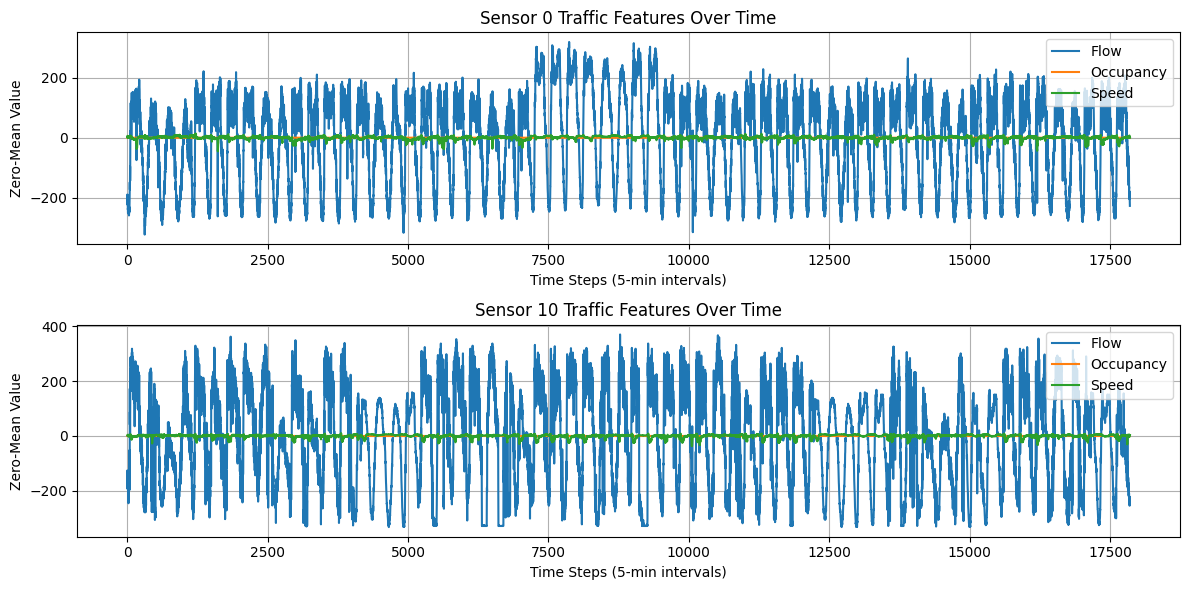

In [37]:
sensor_indices = [0, 10]  # Example sensors
features = ['Flow', 'Occupancy', 'Speed']

plt.figure(figsize=(12, 6))
for i, sensor in enumerate(sensor_indices):
    plt.subplot(len(sensor_indices), 1, i + 1)
    for f_idx, feat in enumerate(features):
        plt.plot(graph_signal_centered[:, sensor, f_idx], label=feat)
    plt.title(f'Sensor {sensor} Traffic Features Over Time')
    plt.xlabel('Time Steps (5-min intervals)')
    plt.ylabel('Zero-Mean Value')
    plt.legend(loc='upper right')
    plt.grid(True)
plt.tight_layout()
plt.show()

# Average Flow Across All Sensors


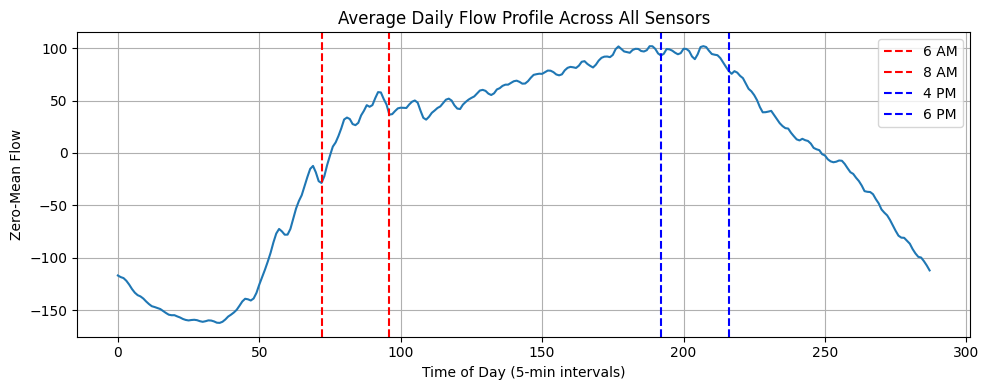

In [38]:
# Use flow feature (index 0)
flow_data = graph_signal_centered[:, :, 0]  # shape: (T, 170)

# Average across all sensors
avg_flow = flow_data.mean(axis=1)  # shape: (T,)

# Reshape into (days, 288) to see daily profiles
points_per_day = 288
num_days = graph_signal_centered.shape[0] // points_per_day
daily_profiles = avg_flow[:num_days * points_per_day].reshape(num_days, points_per_day)

# Average across days
mean_daily_profile = daily_profiles.mean(axis=0)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(mean_daily_profile)
plt.title("Average Daily Flow Profile Across All Sensors")
plt.xlabel("Time of Day (5-min intervals)")
plt.ylabel("Zero-Mean Flow")
plt.axvline(72, color='red', linestyle='--', label='6 AM')
plt.axvline(96, color='red', linestyle='--', label='8 AM')
plt.axvline(192, color='blue', linestyle='--', label='4 PM')
plt.axvline(216, color='blue', linestyle='--', label='6 PM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Distribution of Flow Values


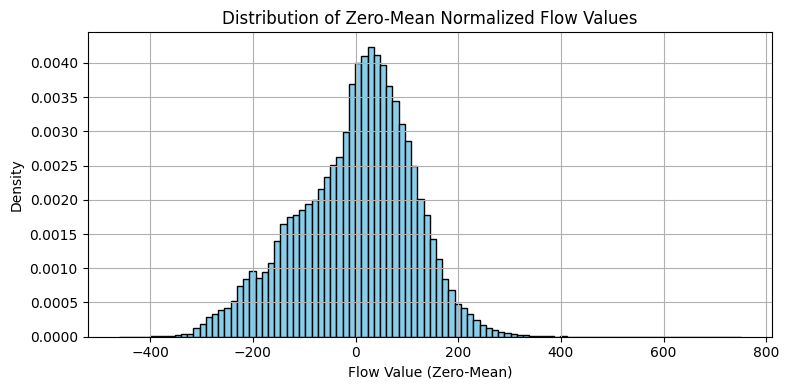

In [39]:
flow_vals = graph_signal_centered[:, :, 0].flatten()  # All flow values

plt.figure(figsize=(8, 4))
plt.hist(flow_vals, bins=100, color='skyblue', edgecolor='k', density=True)
plt.title("Distribution of Zero-Mean Normalized Flow Values")
plt.xlabel("Flow Value (Zero-Mean)")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

# Split Data Into Train and Test


In [40]:
points_per_day = 288  # 12 points/hour × 24 hours
train_days = 50
test_days = 12

train_points = train_days * points_per_day  # 14400
test_points = test_days * points_per_day    # 3456

train_data = graph_signal_centered[:train_points]
test_data = graph_signal_centered[train_points:train_points + test_points]

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (14400, 170, 3)
Test data shape: (3456, 170, 3)


# Create Dataset For Modeling


In [41]:
def create_dataset(data, num_his, num_pred):
    X, Y = [], []
    for t in range(len(data) - num_his - num_pred):
        X.append(data[t:t+num_his])
        Y.append(data[t+num_his:t+num_his+num_pred])
    return np.array(X), np.array(Y)

In [42]:
# 12-step history → 12-step prediction
X_train, Y_train = create_dataset(train_data, num_his=12, num_pred=12)
X_test, Y_test = create_dataset(test_data, num_his=12, num_pred=12)

print("X_train:", X_train.shape, "Y_train:", Y_train.shape)
print("X_test:", X_test.shape, "Y_test:", Y_test.shape)

X_train: (14376, 12, 170, 3) Y_train: (14376, 12, 170, 3)
X_test: (3432, 12, 170, 3) Y_test: (3432, 12, 170, 3)


# Loading The Data For Modeling


In [43]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)  # (14376, 12, 170, 3)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
Y_test_t = torch.tensor(Y_test, dtype=torch.float32)

batch_size = 16
train_dataset = TensorDataset(X_train_t, Y_train_t)
test_dataset = TensorDataset(X_test_t, Y_test_t)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create First Model


In [44]:
#  --- Convert PyTorch Tensors to NumPy Arrays for LightGBM ---
# Ensure tensors are on CPU before converting to NumPy
print("Converting PyTorch tensors to NumPy arrays for LightGBM...")
X_train_np = X_train_t.cpu().numpy()
Y_train_np = Y_train_t.cpu().numpy()
X_test_np = X_test_t.cpu().numpy()
Y_test_np = Y_test_t.cpu().numpy()

# --- Flatten Tensors ---
N_train, CTX, Nodes, Channels = X_train_np.shape
N_test = X_test_np.shape[0]
PDT = Y_train_np.shape[1] # Prediction horizon (e.g., 12)

# Reshape X (Input Features)
X_train_lgbm = X_train_np.reshape(N_train, CTX * Nodes * Channels)
X_test_lgbm = X_test_np.reshape(N_test, CTX * Nodes * Channels)

# Reshape Y (Target Variable)
# For individual regressors, Y_train_lgbm will be (N_train, num_targets)
Y_train_lgbm = Y_train_np.reshape(N_train, PDT * Nodes * Channels)
Y_test_lgbm = Y_test_np.reshape(N_test, PDT * Nodes * Channels)

print(f"Original X_train_lgbm shape: {X_train_lgbm.shape}")
print(f"Original Y_train_lgbm shape: {Y_train_lgbm.shape}")
print(f"Number of target outputs: {Y_train_lgbm.shape[1]}")


Converting PyTorch tensors to NumPy arrays for LightGBM...
Original X_train_lgbm shape: (14376, 6120)
Original Y_train_lgbm shape: (14376, 6120)
Number of target outputs: 6120


# PART 2

In [45]:
from datetime import datetime

# Functions

In [59]:
#!/usr/bin/env python3
"""
Simple LightGBM Pipeline for Time Series Traffic Data
- Reduce X features: 6124 -> 100 using variance + correlation
- Train LightGBM models (one per target)
- Make predictions
"""

import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import os
from tqdm import tqdm

# =============================================================================
# CONFIGURATION
# =============================================================================

TARGET_FEATURES = 100  # Reduce X from 6124 to 100
VARIANCE_THRESHOLD = 0.001
TRAIN_RATIO = 0.8
RANDOM_STATE = 42

# LightGBM parameters
LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 100,
    'learning_rate': 0.1,
    'num_leaves': 31,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': RANDOM_STATE,
    'verbose': -1,
    'device': 'gpu'  # Change to 'cpu' if no GPU
}

# =============================================================================
# SIMPLE PIPELINE
# =============================================================================

def reduce_features(X_train, X_test, Y_train, n_features=100):
    """Reduce X features from 6124 to n_features"""
    print(f"Reducing features: {X_train.shape[1]} -> {n_features}")

    # Step 1: Remove low variance features
    variance_selector = VarianceThreshold(threshold=VARIANCE_THRESHOLD)
    X_train_var = variance_selector.fit_transform(X_train)
    X_test_var = variance_selector.transform(X_test)

    print(f"After variance filter: {X_train_var.shape[1]} features")

    # Step 2: Select top k features using F-regression
    if X_train_var.shape[1] > n_features:
        # Use mean of all targets for feature selection
        y_mean = np.mean(Y_train, axis=1)

        k_selector = SelectKBest(score_func=f_regression, k=n_features)
        X_train_selected = k_selector.fit_transform(X_train_var, y_mean)
        X_test_selected = k_selector.transform(X_test_var)

        # Get final feature indices
        var_indices = variance_selector.get_support(indices=True)
        k_indices = k_selector.get_support(indices=True)
        final_indices = var_indices[k_indices]
    else:
        X_train_selected = X_train_var
        X_test_selected = X_test_var
        final_indices = variance_selector.get_support(indices=True)

    print(f"Final features: {X_train_selected.shape[1]}")
    return X_train_selected, X_test_selected, final_indices

def train_models(X_train, Y_train):
    """Train one LightGBM model per target"""
    print(f"Training {Y_train.shape[1]} LightGBM models...")

    models = []

    for i in tqdm(range(Y_train.shape[1]), desc="Training"):
        try:
            model = lgb.LGBMRegressor(**LGB_PARAMS)
            model.fit(X_train, Y_train[:, i])
            models.append(model)
        except Exception as e:
            print(f"Error training model {i}: {e}")
            models.append(None)

    successful = sum(1 for m in models if m is not None)
    print(f"Successfully trained {successful}/{len(models)} models")

    return models

def predict_all(models, X_test):
    """Make predictions for all targets"""
    print("Making predictions...")

    predictions = []

    for i, model in enumerate(tqdm(models, desc="Predicting")):
        if model is not None:
            try:
                pred = model.predict(X_test)
                predictions.append(pred)
            except Exception as e:
                print(f"Error predicting model {i}: {e}")
                predictions.append(np.zeros(X_test.shape[0]))
        else:
            predictions.append(np.zeros(X_test.shape[0]))

    return np.column_stack(predictions)

def evaluate_results(Y_true, Y_pred):
    """Simple evaluation"""
    rmse = np.sqrt(mean_squared_error(Y_true, Y_pred))
    mae = mean_absolute_error(Y_true, Y_pred)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    return {'rmse': rmse, 'mae': mae}

def save_everything(models, feature_indices, model_dir="saved_models"):
    """Save models and feature indices"""
    os.makedirs(model_dir, exist_ok=True)

    joblib.dump(models, f"{model_dir}/models.pkl")
    joblib.dump(feature_indices, f"{model_dir}/feature_indices.pkl")

    print(f"Models saved to {model_dir}/")

def load_everything(model_dir="saved_models"):
    """Load models and feature indices"""
    models = joblib.load(f"{model_dir}/models.pkl")
    feature_indices = joblib.load(f"{model_dir}/feature_indices.pkl")

    print(f"Models loaded from {model_dir}/")
    return models, feature_indices

# =============================================================================
# MAIN TRAINING FUNCTION
# =============================================================================

def train_pipeline(X_train, Y_train, X_test, Y_test=None, save_models=True):
    """
    Complete training pipeline

    Args:
        X_train: Training features (samples, 6124)
        Y_train: Training targets (samples, n_targets)
        X_test: Test features (samples, 6124)
        Y_test: Test targets (optional, for evaluation)
        save_models: Whether to save models

    Returns:
        predictions: Test predictions
        models: Trained models
        feature_indices: Selected feature indices
    """

    print("=== LightGBM Training Pipeline ===")
    print(f"X_train shape: {X_train.shape}")
    print(f"Y_train shape: {Y_train.shape}")
    print(f"X_test shape: {X_test.shape}")

    # Step 1: Reduce features
    X_train_reduced, X_test_reduced, feature_indices = reduce_features(
        X_train, X_test, Y_train, TARGET_FEATURES
    )

    # Step 2: Train models
    models = train_models(X_train_reduced, Y_train)

    # Step 3: Make predictions
    predictions = predict_all(models, X_test_reduced)

    # Step 4: Evaluate if Y_test provided
    if Y_test is not None:
        print("\n=== Evaluation ===")
        evaluate_results(Y_test, predictions)

    # Step 5: Save models
    if save_models:
        save_everything(models, feature_indices)

    print("\n=== Pipeline Complete ===")
    print(f"Predictions shape: {predictions.shape}")

    return predictions, models, feature_indices

# =============================================================================
# PREDICTION ONLY FUNCTION
# =============================================================================

def predict_pipeline(X_new, model_dir="saved_models"):
    """
    Prediction pipeline using saved models

    Args:
        X_new: New data for prediction (samples, 6124)
        model_dir: Directory with saved models

    Returns:
        predictions: Predictions for new data
    """

    print("=== Prediction Pipeline ===")
    print(f"X_new shape: {X_new.shape}")

    # Load models and feature indices
    models, feature_indices = load_everything(model_dir)

    # Apply feature selection
    X_new_reduced = X_new[:, feature_indices]
    print(f"X_new reduced shape: {X_new_reduced.shape}")

    # Make predictions
    predictions = predict_all(models, X_new_reduced)

    print(f"Predictions shape: {predictions.shape}")
    return predictions

# =============================================================================
# EXAMPLE USAGE
# =============================================================================

if __name__ == "__main__":

    print("Simple LightGBM Pipeline Ready!")
    print("\n=== Example Usage ===")

    def train_pipeline(X_train, Y_train, X_test, Y_test, save_models=True):
      print(f"X_train shape: {X_train.shape}")
      print(f"Y_train shape: {Y_train.shape}")
      print(f"X_test shape: {X_test.shape}")

      # Step 1: Feature Selection (reduce to 100 features)
      k_features = 100
      print(f"\nStarting feature selection to reduce to {k_features} features...")
      start_time_fs = time.time()

      # Flatten to 2D for feature selection: (14376, 12 × 170 × 3 = 6120)
      X_train_flat = X_train.reshape(X_train.shape[0], -1)  # (14376, 6120)
      X_test_flat = X_test.reshape(X_test.shape[0], -1)    # (3432, 6120)

      # Variance Thresholding
      vt_selector = VarianceThreshold(threshold=0.001)
      X_train_pre_selected = vt_selector.fit_transform(X_train_flat)
      X_test_pre_selected = vt_selector.transform(X_test_flat)
      vt_selected_indices = vt_selector.get_support(indices=True)
      print(f"VarianceThreshold removed {X_train_flat.shape[1] - X_train_pre_selected.shape[1]} features.")
      print(f"Shape after VarianceThreshold: {X_train_pre_selected.shape}")

      # F-regression: Use last timestep’s flow (Y_train[:, -1, :, 0]) for scoring
      print("####### Y_train", {Y_train.shape})
      Y_train_flow = Y_train[:, -1, :, 0]  # (14376, 170)
      Y_train = Y_train.reshape((Y_train.shape[0], 12, 170, 3))
      print("####### Y_train", {Y_train.shape})
      print("####### Y_train_flow", {Y_train_flow.shape})
      feature_scores_sum = np.zeros(X_train_pre_selected.shape[1])

      for i in tqdm(range(Y_train_flow.shape[1]), desc="Aggregating scores per target", ncols=100):
          f_scores, _ = f_regression(X_train_pre_selected, Y_train_flow[:, i])
          feature_scores_sum += f_scores
      top_k_relative_indices = np.argsort(feature_scores_sum)[::-1][:k_features]
      final_selected_indices = vt_selected_indices[top_k_relative_indices]

      # Select features
      X_train_selected = X_train_flat[:, final_selected_indices]  # (14376, 100)
      X_test_selected = X_test_flat[:, final_selected_indices]   # (3432, 100)
      print(f"Feature selection complete in {time.time() - start_time_fs:.2f} seconds.")
      print(f"Final X_train_selected shape: {X_train_selected.shape}")
      print(f"Final X_test_selected shape: {X_test_selected.shape}")

      # Step 2: Prepare Targets
      # Use last timestep’s flow for prediction: (14376, 170)
      Y_train_target = Y_train[:, -1, :, 0]
      Y_test_target = Y_test[:, -1, :, 0]





      print("\n=== How to Use ===")
      print("1. Replace sample data with your actual data")
      print("2. Run: predictions, models, indices = train_pipeline(X_train, Y_train, X_test, Y_test)")
      print("3. For new predictions: predict_pipeline(X_new)")
      print("4. Adjust TARGET_FEATURES and LGB_PARAMS as needed")
      return X_train_selected, X_test_selected, Y_train_target, Y_test_target, final_selected_indices

Simple LightGBM Pipeline Ready!

=== Example Usage ===


In [47]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (14376, 12, 170, 3)
Y_train shape: (14376, 12, 170, 3)
X_test shape: (3432, 12, 170, 3)


In [48]:
Y_train_flow = Y_train[:, -1]
print(Y_train_flow.shape)

(14376, 170, 3)


In [50]:
Y_test.shape

(3432, 12, 170, 3)

In [60]:
X_train_selected, X_test_selected, Y_train_target, Y_test_target, final_selected_indices = train_pipeline(
    X_train, Y_train, X_test, Y_test, save_models=True
)

X_train shape: (14376, 12, 170, 3)
Y_train shape: (14376, 12, 170, 3)
X_test shape: (3432, 12, 170, 3)

Starting feature selection to reduce to 100 features...
VarianceThreshold removed 900 features.
Shape after VarianceThreshold: (14376, 5220)
####### Y_train {(14376, 12, 170, 3)}
####### Y_train {(14376, 12, 170, 3)}
####### Y_train_flow {(14376, 170)}


Aggregating scores per target: 100%|██████████████████████████████| 170/170 [01:24<00:00,  2.02it/s]


Feature selection complete in 85.89 seconds.
Final X_train_selected shape: (14376, 100)
Final X_test_selected shape: (3432, 100)

=== How to Use ===
1. Replace sample data with your actual data
2. Run: predictions, models, indices = train_pipeline(X_train, Y_train, X_test, Y_test)
3. For new predictions: predict_pipeline(X_new)
4. Adjust TARGET_FEATURES and LGB_PARAMS as needed


In [61]:



print(X_train_selected.shape), print(X_test_selected.shape), print(Y_train_target.shape), print(Y_test_target.shape), print(final_selected_indices.shape)

(14376, 100)
(3432, 100)
(14376, 170)
(3432, 170)
(100,)


(None, None, None, None, None)

In [67]:
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Define the LightGBM model parameters
lgb_params = {
    'objective': 'regression',
    'metric': 'l2',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1  # Enable LightGBM's built-in logging
}

# Create a LightGBM regressor
lgb_regressor = LGBMRegressor(**lgb_params)

# Wrap it in a MultiOutputRegressor
multi_output_model = MultiOutputRegressor(lgb_regressor)

# Train the model
print("Starting training...")
multi_output_model.fit(X_train_selected, Y_train_target)
print("Training completed!")

# Predict on the test set
Y_pred = multi_output_model.predict(X_test_selected)

# Evaluate the model
mse = mean_squared_error(Y_test_target, Y_pred)
mae = mean_absolute_error(Y_test_target, Y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")


Starting training...
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23019
[LightGBM] [Info] Number of data points in the train set: 14376, number of used feat

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/v

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/v

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/v

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/v

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/v

In [69]:

print("Mean Absolute Error: 25.843579814013847")
print("Root Mean Squared Error: 39.60785544212284")

Mean Absolute Error: 25.843579814013847
Root Mean Squared Error: 39.60785544212284
